# Detecção com Haar Cascades (Face, Olhos e Sorriso)

## 1. O que são Haar Cascades?
São modelos de Machine Learning "clássicos" (pré-Deep Learning) treinados para detectar objetos específicos.
Eles são extremamente rápidos e funcionam bem em CPUs simples, sendo ideais para sistemas embarcados leves.

O OpenCV já traz modelos treinados (arquivos `.xml`) para faces, olhos, carros, placas, etc.

In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

def mostrar_imagem(imagem, titulo="Imagem"):
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(imagem_rgb)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [2]:
# Caminhos para os arquivos XML do próprio OpenCV
# cv2.data.haarcascades retorna o caminho da pasta onde eles estão instalados
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# 2. Detecção em Imagem Estática

Vamos carregar nossa imagem de teste e converter para **Escala de Cinza**.
O Haar Cascade funciona analisando padrões de claro/escuro, então a cor não importa (e atrapalha a performance).

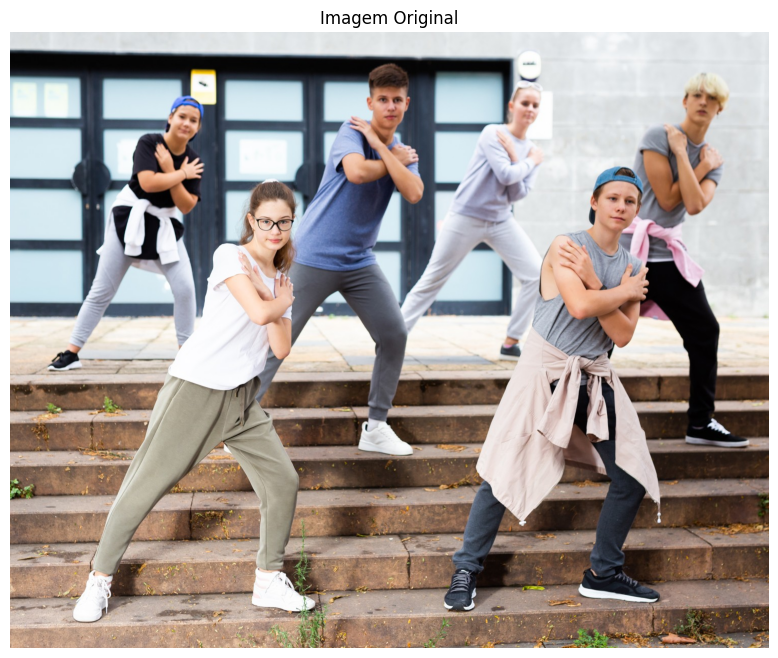

In [3]:
img = cv2.imread(r"../amostras/image-pose.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

mostrar_imagem(img, "Imagem Original")

### 2.1 Conceito de ROI (Region of Interest)
Detectar olhos na imagem inteira é perigoso: o computador pode achar que uma mancha na parede é um olho.
**A abordagem correta é:**
1. Detectar o **Rosto**.
2. Recortar a região do rosto (**ROI**).
3. Procurar olhos e sorrisos **apenas dentro desse recorte**.

Isso aumenta a precisão e velocidade!

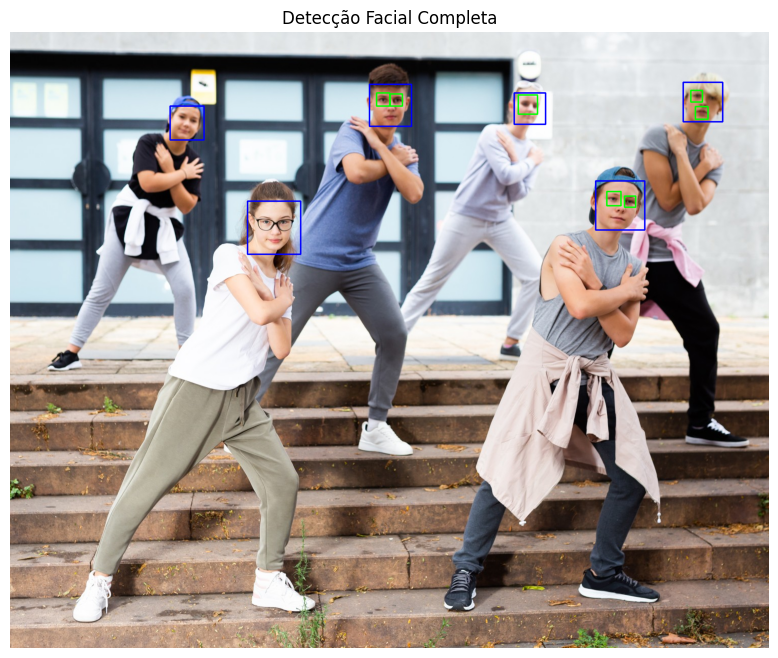

In [4]:
# Clonar imagem para desenhar
img_resultado = img.copy()

# 1. Detectar Faces
# scaleFactor=1.1: Reduz a imagem em 10% a cada escala para procurar rostos de tamanhos diferentes
# minNeighbors=5: Quantos retângulos candidatos devem existir para validar a detecção (evita falsos positivos)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)

for (x, y, w, h) in faces:
    # Desenha retângulo no rosto (Azul)
    cv2.rectangle(img_resultado, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # --- CRIANDO ROI (Região de Interesse) ---
    # Pegamos apenas a área cinza do rosto e a área colorida correspondente
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img_resultado[y:y+h, x:x+w]
    
    # 2. Detectar Olhos (DENTRO da ROI)
    olhos = eye_cascade.detectMultiScale(roi_gray, 1.1, 10)
    for (ex, ey, ew, eh) in olhos:
        # Desenha retângulo nos olhos (Verde)
        # Note que as coordenadas (ex, ey) são relativas à ROI, não à imagem original
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
        
    # 3. Detectar Sorriso (DENTRO da ROI)
    # scaleFactor alto (1.7) e minNeighbors alto (20) porque sorriso gera muitos falsos positivos
    sorrisos = smile_cascade.detectMultiScale(roi_gray, 1.7, 20)
    for (sx, sy, sw, sh) in sorrisos:
        cv2.rectangle(roi_color, (sx, sy), (sx+sw, sy+sh), (0, 0, 255), 2)
        cv2.putText(img_resultado, "Sorriso!", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

mostrar_imagem(img_resultado, "Detecção Facial Completa")

# 3. Detecção em Tempo Real (Webcam)

Vamos aplicar a mesma lógica na webcam.

In [5]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret: break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # ROI para olhos e sorriso
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 10)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
            
        smiles = smile_cascade.detectMultiScale(roi_gray, 1.8, 20)
        for (sx, sy, sw, sh) in smiles:
            cv2.rectangle(roi_color, (sx, sy), (sx+sw, sy+sh), (0, 0, 255), 2)
            cv2.putText(frame, "SORRISO DETECTADO", (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.imshow('Haar Cascade - Face & Olhos', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()